In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import datasets, transforms
TrainSet = datasets.MNIST('./data', train=True, download=True)
TestSet = datasets.MNIST('./data', train=False, download=True)
I_train = TrainSet.data.numpy()[:1000]
label_train = TrainSet.targets.numpy()[:1000]
I_test= TestSet.data.numpy()[:1000]
label_test = TestSet.targets.numpy()[:1000]

Q1

In [ ]:
class convolution:
  def __init__(self,NumOfFilters,SizeOfFilter):
    self.NumOfFilters=NumOfFilters
    self.SizeOfFilter=SizeOfFilter
    self.Filter_convolv=np.random.randn(NumOfFilters,SizeOfFilter,SizeOfFilter)/(SizeOfFilter*SizeOfFilter)

  def ImageRegion(self,image):
    height,width=image.shape
    self.image=image
    for j in range(height-self.SizeOfFilter+1):
      for k in range(width-self.SizeOfFilter+1):
        PatchOfImage=image[j:(j+self.SizeOfFilter),k:(k+self.SizeOfFilter)]
        yield PatchOfImage,j,k
    
  def transform(self,img):
    h,w,c=img.shape
    Timage=np.float64(np.zeros((h,w)))
    for i in range(h):
      for j in range(w):
        for k in range(c):
          Timage[i][j]+=img[i][j][k]
          
    return Timage

  def forwardPropagation(self,image,padding):
    self.image_shape=image.shape
    image=self.transform(image)
    height,width=image.shape
    Output_convolv=np.zeros((height-self.SizeOfFilter+1,width-self.SizeOfFilter+1,self.NumOfFilters))
    for PatchOfImage,i,j in self.ImageRegion(image):
      Output_convolv[i,j]=np.sum(PatchOfImage*self.Filter_convolv,axis=(1,2))
    self.Output_convolv=PaddingAdded(Output_convolv,padding)
    return self.Output_convolv

  def backwardPropagation(self,dL_dout,learning_rate):
    DlDfparams=np.zeros(self.Filter_convolv.shape)
    for PatchOfImage,i,j in self.ImageRegion(self.image):
      for k in range(self.NumOfFilters):
        DlDfparams[k]+=PatchOfImage*dL_dout[i,j,k]    
    self.Filter_convolv-=learning_rate*DlDfparams
    return DlDfparams


In [ ]:
def PaddingAdded(img, padding):
    h,w,c = img.shape
    p_h, p_w=padding
    Arr_pad = np.ones((h + p_h*2, w + p_w*2,c))
    Arr_pad[p_h:-p_h, p_w: -p_w,:] = img    
    return Arr_pad

In [ ]:
class MaxPooling:

  def __init__(self,SizeOfFilter):
    self.SizeOfFilter=SizeOfFilter
  
  def ImageRegion(self,image):
    new_height=image.shape[0]//self.SizeOfFilter
    new_width=image.shape[1]//self.SizeOfFilter
    self.image=image
    for i in range(new_height):
      for j in range(new_width):
        PatchOfImage=image[(i*self.SizeOfFilter):(i*self.SizeOfFilter+self.SizeOfFilter),(j*self.SizeOfFilter):(j*self.SizeOfFilter+self.SizeOfFilter)]
        yield PatchOfImage,i,j
  
  def forwardPropagation(self,image):
    height,width,NumOfFilters=image.shape
    output=np.zeros((height//self.SizeOfFilter,width//self.SizeOfFilter,NumOfFilters))
    for PatchOfImage,i,j in self.ImageRegion(image):
      output[i,j]=np.amax(PatchOfImage,axis=(0,1))
    return output

  def backwardPropagation(self,dL_dout):
    DlDmaxpool=np.zeros(self.image.shape)
    for PatchOfImage,i,j in self.ImageRegion(self.image):
      height,width,NumOfFilters=PatchOfImage.shape
      valMax=np.amax(PatchOfImage,axis=(0,1))
      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(NumOfFilters):
            if PatchOfImage[i1,j1,k1]==valMax[k1]:
              DlDmaxpool[i*self.SizeOfFilter+i1,j*self.SizeOfFilter+j1,k1]=dL_dout[i,j,k1]
    return DlDmaxpool


In [ ]:
class ArtNeuNet:

  def __init__(self,input_node,output_node):
    self.weight=np.random.randn(input_node,output_node)/input_node
    self.bias=np.zeros(output_node)
    self.change=0
    self.weight_config=None
    self.bias_config=None

  def forwardPropagation(self,image):
    self.orig_im_shape=image.shape
    ModifiedImage=image.flatten()
    self.bottleneck=ModifiedImage
    self.modified_input=ModifiedImage
    output_val=np.dot(ModifiedImage,self.weight)+self.bias
    self.out=output_val
    ExceptedOutput=np.exp(output_val)
    return ExceptedOutput/np.sum(ExceptedOutput,axis=0)
  
  def backwardPropagation(self,dL_dout,learning_rate,momentum,verbose):
    for i,grad in enumerate(dL_dout):
      if grad==0:
        continue
      transformation_eq=np.exp(self.out)
      S_full =np.sum(transformation_eq)
      DERyDerz= -transformation_eq[i]*transformation_eq/(S_full**2)
      DERyDerz[i]=transformation_eq[i]*(S_full-transformation_eq[i])/(S_full**2)
      DERzDerw=self.modified_input
      dz_db=1
      dz_d_inp=self.weight
      DERlDerz=grad*DERyDerz
      DERlDerw=DERzDerw[np.newaxis].T @ DERlDerz[np.newaxis]
      DERlDerb=DERlDerz*dz_db
      DERlDerinput=dz_d_inp @ DERlDerz
      if verbose=='vanila':
        self.weight-=learning_rate*DERlDerw
        self.bias-=learning_rate*DERlDerb
      elif verbose=='momentum':
        Newchg = learning_rate*DERlDerw+ momentum * self.change
        self.weight -= Newchg
        self.change = Newchg
        self.bias-=learning_rate*DERlDerb
      else:
        self.weight,self.weight_config=rmsprop(self.weight,DERlDerw,self.weight_config)
        self.bias,self.bias_config=rmsprop(self.bias,DERlDerb,self.bias_config)
      return DERlDerinput.reshape(self.orig_im_shape)

Q2

In [ ]:
def ConvForwad(image,label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo):  
  fwdprop_=convolution1.forwardPropagation((image/255)-0.5,(2,2))
  fwdprop_=FirstPooling.forwardPropagation(fwdprop_)
  fwdprop=convolution2.forwardPropagation(fwdprop_,(2,2))
  fwdprop=SecondPooling.forwardPropagation(fwdprop)
  fwdprop=FcOne.forwardPropagation(fwdprop_)
  crossEntropyLoss=-np.log(fwdprop[label])
  EvalvAccu=1 if np.argmax(fwdprop)==label else 0
  return fwdprop,crossEntropyLoss,EvalvAccu

def training_cnn(image,label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo,verbose,learning_rate=0.001,momentum=0.9):
  out,loss,acc=ConvForwad(image,label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo)
  gradient=np.zeros(10)
  gradient[label]=-1/out[label]
  GradientDescent_=FcOne.backwardPropagation(gradient,learning_rate,momentum,verbose)
  GradientDescent=SecondPooling.backwardPropagation(GradientDescent_)
  GradientDescent=convolution2.backwardPropagation(GradientDescent,learning_rate)
  GradientDescent=FirstPooling.backwardPropagation(GradientDescent_)
  GradientDescent=convolution1.backwardPropagation(GradientDescent,learning_rate)
  return loss,acc

In [ ]:
convolution1=convolution(4,5)
FirstPooling=MaxPooling(2)
convolution2=convolution(4,5)
SecondPooling=MaxPooling(2)
FcOne=ArtNeuNet(14*14*4,10)
FcTwo=ArtNeuNet(49,10)

In [ ]:
img=I_train[0]
ConvForwad(img.reshape(28,28,1),label_train[0],convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo)

(array([0.09783949, 0.09835085, 0.10475059, 0.10100007, 0.09895779,
        0.09987983, 0.10275768, 0.09989321, 0.09889097, 0.09767951]),
 2.3037874785733097,
 0)

Q3

Vanilla SGD

In [ ]:

convolution1=convolution(4,5)
FirstPooling=MaxPooling(2)
convolution2=convolution(4,5)
SecondPooling=MaxPooling(2)
FcOne=ArtNeuNet(14*14*4,10)
FcTwo=ArtNeuNet(49,10)

LossTraining,LossTesting=[],[]
for epoch in range(15):
  print('Epoch %d'%(epoch+1))
  loss=0
  CorrectNumber=0
  for i ,(im,label) in enumerate(zip(I_train,label_train)):
    l1,accu=training_cnn(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo,'vanila')
    loss+=l1
    CorrectNumber+=accu
  LossTraining.append(loss/len(I_train))
  print('Average Loss',loss/len(I_train),'Accuracy :',CorrectNumber/len(I_train))
  print("start of testing")
  loss=0
  CorrectNumber=0
  for im,label in zip(I_test,label_test):
    _,l1,accu=ConvForwad(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo)
    loss+=l1
    CorrectNumber+=accu
  NumberOfTests=len(I_test)
  LossTesting.append(loss/NumberOfTests)
  print('Loss during Testing',loss/NumberOfTests)
  print('Accuracy while Testing ',CorrectNumber/NumberOfTests)

Epoch 1
Average Loss 2.255396080754771 Accuracy : 0.16
start of testing
Loss during Testing 1.987656810031605
Accuracy while Testing  0.414
Epoch 2
Average Loss 1.2838380496584056 Accuracy : 0.657
start of testing
Loss during Testing 1.0128536720289871
Accuracy while Testing  0.66
Epoch 3
Average Loss 0.7105135518592466 Accuracy : 0.787
start of testing
Loss during Testing 0.7992353715920378
Accuracy while Testing  0.73
Epoch 4
Average Loss 0.574459572010362 Accuracy : 0.819
start of testing
Loss during Testing 0.7312062083268728
Accuracy while Testing  0.756
Epoch 5
Average Loss 0.5142526833126263 Accuracy : 0.835
start of testing
Loss during Testing 0.6972838593631051
Accuracy while Testing  0.767
Epoch 6
Average Loss 0.4777199693602024 Accuracy : 0.844
start of testing
Loss during Testing 0.6758729283928699
Accuracy while Testing  0.773
Epoch 7
Average Loss 0.4517819163519551 Accuracy : 0.857
start of testing
Loss during Testing 0.6606662676643439
Accuracy while Testing  0.782
Epoch

Momentum

In [ ]:
convolution1=convolution(4,5)
FirstPooling=MaxPooling(2)
convolution2=convolution(4,5)
SecondPooling=MaxPooling(2)
FcOne=ArtNeuNet(14*14*4,10)
FcTwo=ArtNeuNet(49,10)
LossTraining,LossTesting=[],[]
for epoch in range(15):
  print('Epoch %d'%(epoch+1))
  loss=0
  CorrectNumber=0
  for i ,(im,label) in enumerate(zip(I_train,label_train)):
    l1,accu=training_cnn(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo,'momentum')
    loss+=l1
    CorrectNumber+=accu
  LossTraining.append(loss/len(I_train))
  print('Average Loss:',loss/len(I_train),'Accuracy :',CorrectNumber/len(I_train))
  print("start of testing")
  loss=0
  CorrectNumber=0
  for im,label in zip(I_test,label_test):
    _,l1,accu=ConvForwad(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo)
    loss+=l1
    CorrectNumber+=accu
  NumberOfTests=len(I_test)
  LossTesting.append(loss/NumberOfTests)
  print('Loss during Testing',loss/NumberOfTests)
  print('Accuracy while Testing ',CorrectNumber/NumberOfTests)

Epoch 1
Average Loss: 1.6705869023332143 Accuracy : 0.488
start of testing
Loss during Testing 0.9563101031399868
Accuracy while Testing  0.704
Epoch 2
Average Loss: 1.011738912611775 Accuracy : 0.73
start of testing
Loss during Testing 1.0319114294265588
Accuracy while Testing  0.723
Epoch 3
Average Loss: 0.9451053191832937 Accuracy : 0.768
start of testing
Loss during Testing 1.1211045876027417
Accuracy while Testing  0.732
Epoch 4
Average Loss: 0.7938077622433779 Accuracy : 0.819
start of testing
Loss during Testing 1.1832565293544877
Accuracy while Testing  0.732
Epoch 5
Average Loss: 0.7107741062086695 Accuracy : 0.846
start of testing
Loss during Testing 1.367564544866835
Accuracy while Testing  0.726
Epoch 6
Average Loss: 0.6598561883381825 Accuracy : 0.864
start of testing
Loss during Testing 1.2818485096342862
Accuracy while Testing  0.745
Epoch 7
Average Loss: 0.5970519862269646 Accuracy : 0.873
start of testing
Loss during Testing 1.384515349353578
Accuracy while Testing  0.

**RMSPROP**

In [ ]:
def rmsprop(x, dx, config=None):
    if config is None: config = {}
    config.setdefault('learning_rate', 0.001)
    config.setdefault('decay_rate', 0.9)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('cache', np.zeros_like(x))
    next_x = None
    decay_rate = config['decay_rate']
    cache = config['cache']
    cache = decay_rate * cache + (1 - decay_rate) * dx ** 2
    next_x = x - config['learning_rate'] * dx / (np.sqrt(cache) + config['epsilon'])
    config['cache'] = cache
    return next_x, config

In [ ]:
convolution1=convolution(4,5)
FirstPooling=MaxPooling(2)
convolution2=convolution(4,5)
SecondPooling=MaxPooling(2)
FcOne=ArtNeuNet(14*14*4,10)
FcTwo=ArtNeuNet(49,10)
LossTraining,LossTesting=[],[]
for epoch in range(15):
  print('Epoch %d'%(epoch+1))
  loss=0
  CorrectNumber=0
  for i ,(im,label) in enumerate(zip(I_train,label_train)):
    l1,accu=training_cnn(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo,'rms_prop')
    loss+=l1
    CorrectNumber+=accu
  LossTraining.append(loss/len(I_train))
  print('Average Loss',loss/len(I_train),'Accuracy :',CorrectNumber/len(I_train))
  print("start of testing")
  loss=0
  CorrectNumber=0
  for im,label in zip(I_test,label_test):
    _,l1,accu=ConvForwad(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo)
    loss+=l1
    CorrectNumber+=accu
  NumberOfTests=len(I_test)
  LossTesting.append(loss/NumberOfTests)
  print('Loss during Testing',loss/NumberOfTests)
  print('Accuracy while Testing ',CorrectNumber/NumberOfTests)

Epoch 1
Average Loss 1.191204064295171 Accuracy : 0.615
start of testing
Loss during Testing 0.9492838239024558
Accuracy while Testing  0.67
Epoch 2
Average Loss 0.6270788355372591 Accuracy : 0.804
start of testing
Loss during Testing 0.8189588171769797
Accuracy while Testing  0.721
Epoch 3
Average Loss 0.5494738324976685 Accuracy : 0.829
start of testing
Loss during Testing 0.7637150028688168
Accuracy while Testing  0.76
Epoch 4
Average Loss 0.502211117633819 Accuracy : 0.851
start of testing
Loss during Testing 0.7391489785734621
Accuracy while Testing  0.774
Epoch 5
Average Loss 0.468785517474971 Accuracy : 0.869
start of testing
Loss during Testing 0.7295522692400058
Accuracy while Testing  0.789
Epoch 6
Average Loss 0.444319756454521 Accuracy : 0.881
start of testing
Loss during Testing 0.7285833816781015
Accuracy while Testing  0.794
Epoch 7
Average Loss 0.42540490229166666 Accuracy : 0.886
start of testing
Loss during Testing 0.7327858942782087
Accuracy while Testing  0.797
Epoc

Q4

In [ ]:
convolution1=convolution(4,5)
FirstPooling=MaxPooling(2)
convolution2=convolution(4,5)
SecondPooling=MaxPooling(2)
FcOne=ArtNeuNet(14*14*4,10)
FcTwo=ArtNeuNet(49,10)
LossTraining,LossTesting=[],[]
for epoch in range(15):
  print('Epoch %d'%(epoch+1))
  shuffle_index=np.random.permutation(len(I_train))
  I_train=I_train[shuffle_index]
  label_train=label_train[shuffle_index]
  loss=0
  CorrectNumber=0
  for i ,(im,label) in enumerate(zip(I_train,label_train)):
    l1,accu=training_cnn(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo,'vanila')
    loss+=l1
    CorrectNumber+=accu
  LossTraining.append(loss/len(I_train))
  print('Average Loss',loss/len(I_train),'Accuracy :',CorrectNumber/len(I_train))
  print("start of testing")
  loss=0
  CorrectNumber=0
  for im,label in zip(I_test,label_test):
    _,l1,accu=ConvForwad(im.reshape(28,28,1),label,convolution1,FirstPooling,convolution2,SecondPooling,FcOne,FcTwo)
    loss+=l1
    CorrectNumber+=accu
  NumberOfTests=len(I_test)
  LossTesting.append(loss/NumberOfTests)
  print('Loss during Testing',loss/NumberOfTests)
  print('Accuracy while Testing ',CorrectNumber/NumberOfTests)

Epoch 1
Average Loss 2.2169393562243047 Accuracy : 0.196
start of testing
Loss during Testing 1.8442801051928577
Accuracy while Testing  0.525
Epoch 2
Average Loss 1.1812536603147674 Accuracy : 0.686
start of testing
Loss during Testing 0.9169948810460719
Accuracy while Testing  0.727
Epoch 3
Average Loss 0.6963014969591358 Accuracy : 0.777
start of testing
Loss during Testing 0.7931124711514776
Accuracy while Testing  0.722
Epoch 4
Average Loss 0.5779962793904506 Accuracy : 0.812
start of testing
Loss during Testing 0.6375713642155451
Accuracy while Testing  0.788
Epoch 5
Average Loss 0.5111298157177222 Accuracy : 0.843
start of testing
Loss during Testing 0.6815835278891721
Accuracy while Testing  0.77
Epoch 6
Average Loss 0.45735802028969674 Accuracy : 0.856
start of testing
Loss during Testing 0.7309620580538515
Accuracy while Testing  0.769
Epoch 7
Average Loss 0.44915019570315445 Accuracy : 0.858
start of testing
Loss during Testing 0.6628663065177608
Accuracy while Testing  0.78

Q5

A

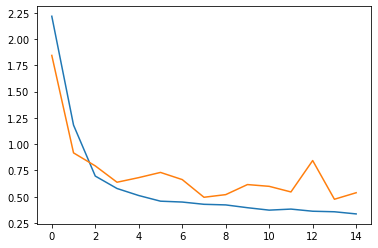

In [ ]:
plt.plot(LossTraining)
plt.plot(LossTesting)
plt.show()

B

In [ ]:
def plotting(img):
  plt.imshow(img)
  plt.style.use("seaborn")
  plt.title(str(img.shape))
  plt.show()

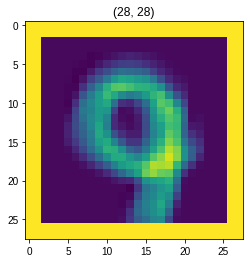

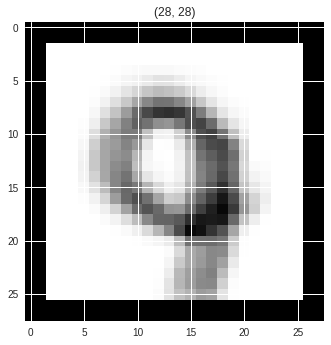

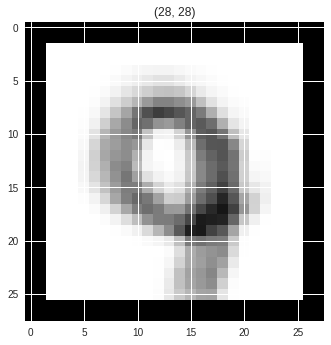

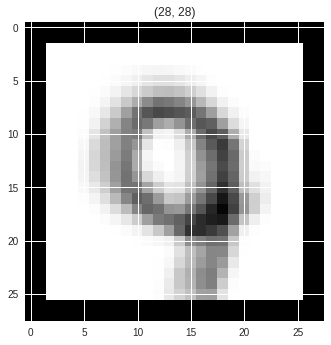

In [ ]:
for i in range(4):
  plotting(convolution1.Output_convolv[:,:,i])

c

In [ ]:
print('Accuracy of classifier ',CorrectNumber/NumberOfTests)

Accuracy of classifier  0.814


Q6

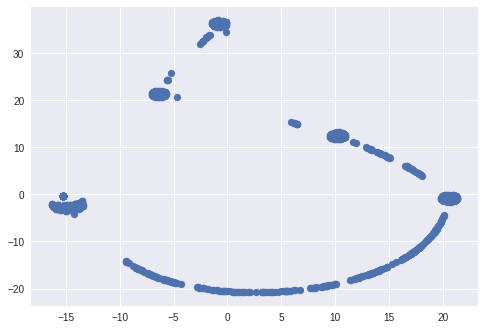

In [ ]:
from sklearn.manifold import TSNE
embedX = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(FcOne.bottleneck.reshape(-1,1))
plt.scatter(embedX[:,0],embedX[:,1])
plt.show()